In [ ]:
import torch
import torch.nn as nn
from google.colab import drive
import numpy as np
import re
import nltk
import string
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext import transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

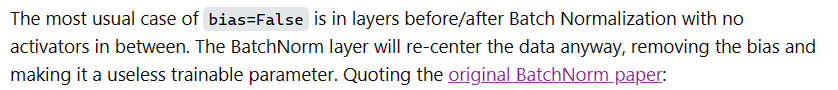

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embedding_size, heads_num):
    super(SelfAttention, self).__init__()

    self.embedding_size = embedding_size
    self.heads_num = heads_num
    self.dim_of_head = embedding_size // heads_num # надо чтобы нацело делилось

    self.values = nn.Linear(self.dim_of_head, self.dim_of_head, bias=False)
    self.keys = nn.Linear(self.dim_of_head, self.dim_of_head, bias=False)
    self.queries = nn.Linear(self.dim_of_head, self.dim_of_head, bias=False)

    self.fc_out = nn.Linear(embedding_size, embedding_size)

  def forward(self, values, keys, queries, mask):

    n = queries.shape[0]
    value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

    # у нас типа были (n, len, embedding), а будут (n, len, heads_num, dim_of_heads)
    values = values.reshape(n, value_len, self.heads_num, self.dim_of_head)
    keys = keys.reshape(n, key_len, self.heads_num, self.dim_of_head)
    queries = queries.reshape(n, query_len, self.heads_num, self.dim_of_head)

    values = self.values(values)
    keys = self.keys(keys)
    queries = self.queries(queries)

    QK = torch.einsum('nqhd,nkhd->nhqk', [queries, keys]) # это знаменатель аттеншна
    # (n, heads_num, query_len, key_len)

    if mask is not None:
      QK = QK.masked_fill(mask == 0, float('-1e20')) # заполняем чтобы софтмакс занулил и декодировщик не знал следующие токены

    attention = torch.softmax(QK / (self.embedding_size ** 0.5), dim=3)

    out = torch.einsum('nhqk,nvhd->nqhd', [attention, values]).reshape(n, query_len, self.heads_num * self.dim_of_head)

    # итого размерность out: (n, query_len, heads_num, dim_of_head) -> (n, query_len, embedding_size)

    out = self.fc_out(out)

    return out

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_size, heads_num, dropout, forw_exp):
    super(TransformerBlock, self).__init__()

    self.attention = SelfAttention(embedding_size, heads_num)
    self.norm = nn.LayerNorm(embedding_size)
    self.fc1 = nn.Linear(embedding_size, embedding_size * forw_exp)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(embedding_size * forw_exp, embedding_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, value, key, query, mask):

    attention = self.attention(value, key, query, mask)
    x = self.dropout(self.norm(attention + query)) # тут ещё реализуем скип сразу к нормализовке
    forward = self.fc1(x)
    forward = self.relu(forward)
    forward = self.fc2(forward)
    out = self.dropout(self.norm(forward + x))

    return out

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, embedding_size, heads_num, dropout, forw_exp, device):
    super(DecoderBlock, self).__init__()

    self.device = device
    self.attention = SelfAttention(embedding_size, heads_num)
    self.norm = nn.LayerNorm(embedding_size)
    self.transformerblock = TransformerBlock(embedding_size, heads_num, dropout, forw_exp)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, value, key, src_mask, trgt_mask): # у нас типа подаются значения и ключи, а запрос это результат декодера

    attention = self.attention(x, x, x, trgt_mask)
    query = self.dropout(self.norm(attention + x))
    out = self.transformerblock(value, key, query, src_mask)

    return out

In [ ]:
class Decoder(nn.Module):
  def __init__(self, trgt_vocab_size, embedding_size, num_layers, heads_num, dropout, forw_exp, device, max_len):
    super(Decoder, self).__init__()

    self.device = device
    self.embedding = nn.Embedding(trgt_vocab_size, embedding_size).to(self.device)
    self.pos_embedding = nn.Embedding(max_len, embedding_size).to(self.device)
    self.softmax = nn.Softmax()

    self.blocks = nn.ModuleList([DecoderBlock(embedding_size, heads_num, dropout, forw_exp, device) for i in range(num_layers)])

    self.fc_out = nn.Linear(embedding_size, trgt_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, prev_out, src_mask, trgt_mask): # по идее должен передаваться выход кодировщика, но модель декодер-онли, так что передаём просто предыдущий выход

    n, seq_len = x.shape
    poses = torch.arange(0, seq_len).expand(n, seq_len).to(self.device)
    x = self.dropout(self.embedding(x.to(self.device)) + self.pos_embedding(poses))

    for b in self.blocks:

      x = b(x, prev_out, prev_out, src_mask, trgt_mask)
      prev_out = x

    out = self.fc_out(x)
    out = torch.argmax(self.softmax(out), axis=2)
    out = out.to(torch.float32).requires_grad_()

    return out

In [ ]:
class Transformer(nn.Module):
  def __init__(self, src_vocab_size, trgt_vocab_size, pad_idx, embedding_size=64, num_layers=3, heads_num=4, dropout=0.1, forw_exp=4, device='cuda', max_len=50):
    super(Transformer, self).__init__()

    self.decoder = Decoder(trgt_vocab_size, embedding_size, num_layers, heads_num, dropout, forw_exp, device, max_len)
    self.pad_idx = pad_idx
    self.device = device
    self.src_vocab_size = src_vocab_size
    self.embedding_size = embedding_size
    self.max_len = max_len
    self.dropout = nn.Dropout(dropout)

  def mask_trgt(self, trgt):
    n, trgt_len = trgt.shape
    trgt_mask = torch.tril(torch.ones((trgt_len, trgt_len))).expand(n, 1, trgt_len, trgt_len) # типа делаем треугольную матрицу
    return trgt_mask.to(self.device)

  def embed_src(self, src):

    self.embedding = nn.Embedding(self.src_vocab_size, self.embedding_size).to(self.device)
    self.pos_embedding = nn.Embedding(self.max_len, self.embedding_size).to(self.device)

    src = src.to(self.device)

    n, seq_len = src.shape
    poses = torch.arange(0, seq_len).expand(n, seq_len).to(self.device)
    x = self.dropout(self.embedding(src) + self.pos_embedding(poses))

    return x

  def forward(self, src, trgt):

    src_mask = None
    trgt_mask = self.mask_trgt(trgt)

    out = self.decoder(trgt, self.embed_src(src), src_mask, trgt_mask)

    return out


In [ ]:
# x = torch.tensor([[1, 3, 5, 3, 6, 7, 3, 2, 0], [1, 6, 2, 0, 0, 0, 0, 0, 0]])

# trg = torch.tensor([[1, 7, 3, 3, 9, 7, 5, 0, 0], [1, 3, 8, 9, 2, 0, 0, 0, 0]])

# pad_idx = 0
# src_vocab_size = 10
# trgt_vocab_size = 10

# model = Transformer(src_vocab_size, trgt_vocab_size, pad_idx).to(device)

In [ ]:
# out = model(x, trg[:, :-1])
# print(out.shape)

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def tokenize(tokens, vocab):

  text_transform = transforms.Sequential(
        transforms.VocabTransform(vocab=vocab),
        transforms.AddToken(vocab['<sos>'], begin=True),
        transforms.AddToken(vocab['<eos>'], begin=False)
    )

  tokens = list(map(text_transform, tokens))

  max_len = len(max(tokens, key=len))

  for i in range(len(tokens)):
    tokens[i] = torch.cat((torch.Tensor(tokens[i]), torch.zeros(max_len - len(tokens[i]))))

  return tokens

In [ ]:
def preprocess(link):
  x = []
  y = []
  tokens = []

  file = open(link, "r")
  texts = np.array(file.read().split('\n<|endoftext|>\n'))
  for text in texts:
    text = re.sub('\d+', '', text)
    text = re.sub('[^\s^\w]+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.lower()

    word_list = word_tokenize(text)

    word_list = [word for word in word_list if word not in string.punctuation]

    x.append(word_list[:len(word_list) // 2])
    y.append(word_list[len(word_list) // 2:])

    tokens.append(word_list)

  vocab = build_vocab_from_iterator(
    tokens,
    min_freq=1,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
  )

  x, y = tokenize(x, vocab), tokenize(y, vocab)

  return x, y, vocab

In [ ]:
x, y, vocab = preprocess("/content/drive/My Drive/TinyStories-valid.txt")

In [ ]:
vocab_len = len(vocab.get_stoi())

In [ ]:
src = torch.stack(x)[:50]
trg = torch.stack(y)[:50]

print(src.shape, trg.shape)

torch.Size([50, 429]) torch.Size([50, 430])


In [ ]:
pad_idx = '<pad>'
src_vocab_size = vocab_len
trgt_vocab_size = vocab_len

model = Transformer(src_vocab_size, trgt_vocab_size, pad_idx, max_len=430).to(device)

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
losses = []

for ep in range (1000):

  source = src.to(device).to(torch.int64)
  target = trg.to(device).to(torch.int64)

  outputs = model(source, target)

  target = target.to(torch.float32)

  loss_value = loss(outputs, target)
  loss_value.backward()
  optimizer.step()
  optimizer.zero_grad()
  losses.append(loss_value.item())

  print(f'Эпоха {ep + 1}, Значение функции потерь: {loss_value.item()}')

Эпоха 1, Значение функции потерь: 111862904.0
Эпоха 2, Значение функции потерь: 108618280.0
Эпоха 3, Значение функции потерь: 107558704.0
Эпоха 4, Значение функции потерь: 110879672.0
Эпоха 5, Значение функции потерь: 111850680.0
Эпоха 6, Значение функции потерь: 113485536.0
Эпоха 7, Значение функции потерь: 111133888.0
Эпоха 8, Значение функции потерь: 108521880.0
Эпоха 9, Значение функции потерь: 109062048.0
Эпоха 10, Значение функции потерь: 114552280.0
Эпоха 11, Значение функции потерь: 116021720.0
Эпоха 12, Значение функции потерь: 107809832.0
Эпоха 13, Значение функции потерь: 111181768.0
Эпоха 14, Значение функции потерь: 110599544.0
Эпоха 15, Значение функции потерь: 117074136.0
Эпоха 16, Значение функции потерь: 114319336.0
Эпоха 17, Значение функции потерь: 112908040.0
Эпоха 18, Значение функции потерь: 109745952.0
Эпоха 19, Значение функции потерь: 105997104.0
Эпоха 20, Значение функции потерь: 111645040.0
Эпоха 21, Значение функции потерь: 107065320.0
Эпоха 22, Значение фун

In [ ]:
import matplotlib.pyplot as plt

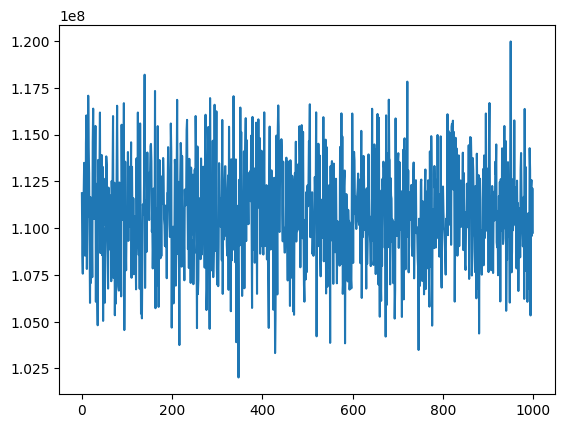

In [ ]:
plt.plot(losses)

In [ ]:
outputs = model(torch.stack(x)[:3].to(device).to(torch.int64), torch.stack(y)[:3].to(device).to(torch.int64))

In [ ]:
outputs

tensor([[ 9293.,  4319.,  2292.,  ...,  3421.,  7784.,  1482.],
        [ 6036.,  8917.,  9600.,  ...,  6836.,  7629., 10312.],
        [ 8518.,  4945.,  5373.,  ...,  5581.,  2954.,  5188.]],
       device='cuda:0', requires_grad=True)

In [ ]:
for i in range(len(outputs[0])):
  print(vocab.get_itos()[outputs[0][i].to(torch.int).item()])

custom
valued
zero
binky
parted
handfuls
bitten
wrinkling
monkey
neat
hates
medical
ruffling
cooked
undeterred
spot
weekend
bowl
cally
gratefully
squished
rangers
universe
bench
kernels
wondeful
louder
best
majesty
jingling
performing
banded
pingo
princely
bowing
pack
curved
shuffle
rocked
hydrated
halves
meats
claus
shelves
firefighting
hatches
speaks
messier
increasing
thespin
spotted
clowning
woman
cob
tip
lana
terrified
halves
accomplishments
rope
feed
borrows
boss
sabrina
repairs
toaster
squashing
stare
corner
stunts
becky
disagreeing
terrible
cally
classmates
cribs
helicopter
trim
state
nine
sunshine
playtime
cone
feeling
swimsuit
interest
known
nah
pike
introducing
abcs
ketchup
beaks
periodic
killed
guessing
temper
operations
passable
suffered
letting
yuck
dodged
neat
footage
saucer
balcony
ray
ruthie
motorcycles
rippled
competing
sent
grumpiness
celebrated
pink
dismayed
alakazam
begun
offers
maybe
smiles
mailed
superpowers
hidden
ll
bid
layer
pouch
merrily
chunks
sofa
banded
f
